In [1]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_generator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  
  hid = Dense(128 * 16 * 16, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((16, 16, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out


In [3]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''

  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(input_layer, out)

  model.summary()

  return model, out

In [4]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      # Dont scale the images back, let keras handle it
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()  

In [5]:
# GAN creation
img_input = Input(shape=(32,32,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

In [6]:

BATCH_SIZE = 16

# # Get training images
(X_train, y_train), (X_test, _) = cifar10.load_data()

# Select Cars
X_train = X_train[y_train[:,0]==1]
print ("Training shape: {}".format(X_train.shape))

# Normalize data
X_train = (X_train - 127.5) / 127.5
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

Training shape: (5000, 32, 32, 3)


d:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 1.8748333261181147, Discriminator Loss: [0.41069314 0.        ]


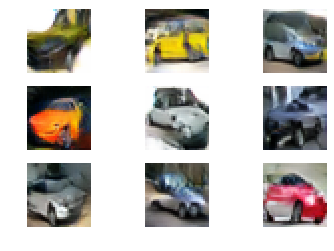

  Epoch: 2, Generator Loss: 1.8732112456972783, Discriminator Loss: [0.41454023 0.        ]


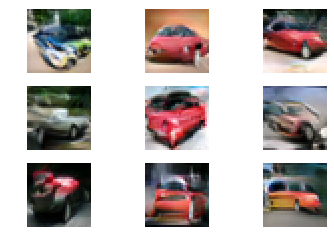

  Epoch: 3, Generator Loss: 2.0389791948673053, Discriminator Loss: [0.4055697 0.       ]


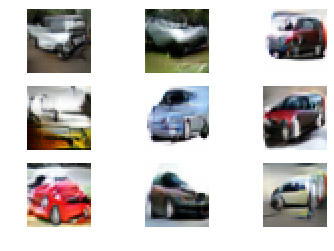

  Epoch: 4, Generator Loss: 2.0343156720583258, Discriminator Loss: [0.41260475 0.        ]


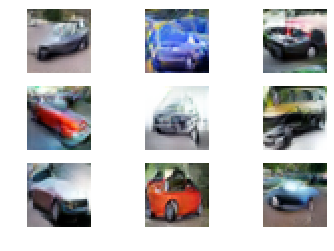

  Epoch: 5, Generator Loss: 2.0555365098974643, Discriminator Loss: [0.39228812 0.        ]


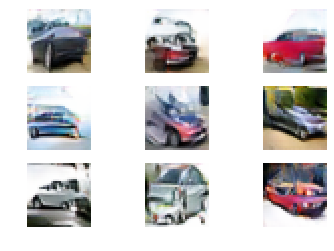

  Epoch: 6, Generator Loss: 1.9804140268227992, Discriminator Loss: [0.3910352 0.       ]


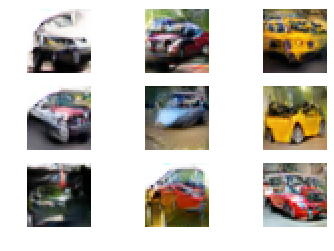

  Epoch: 7, Generator Loss: 2.0837086335970807, Discriminator Loss: [0.3762763 0.       ]


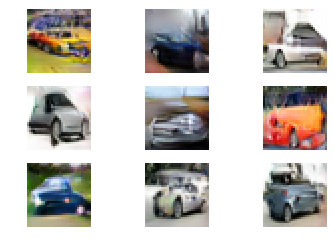

  Epoch: 8, Generator Loss: 2.1501393960072446, Discriminator Loss: [0.3928541 0.       ]


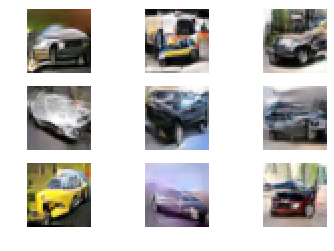

  Epoch: 9, Generator Loss: 2.2116000740191875, Discriminator Loss: [0.3782134 0.       ]


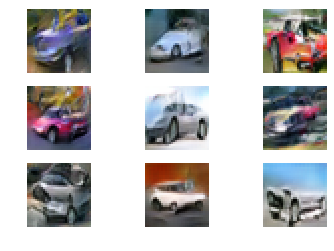

  Epoch: 10, Generator Loss: 2.2722429690452723, Discriminator Loss: [0.36329436 0.        ]


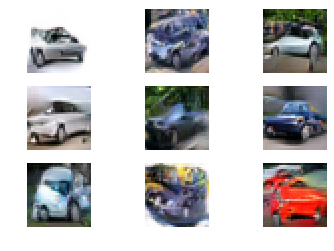

  Epoch: 11, Generator Loss: 2.259072425082708, Discriminator Loss: [0.3787057 0.       ]


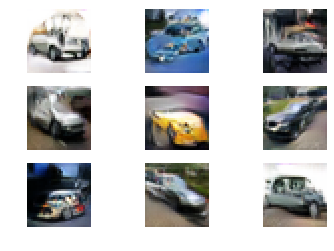

  Epoch: 12, Generator Loss: 2.295746110761777, Discriminator Loss: [0.37025675 0.        ]


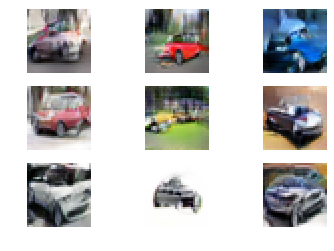

  Epoch: 13, Generator Loss: 2.3267989662977366, Discriminator Loss: [0.37659422 0.        ]


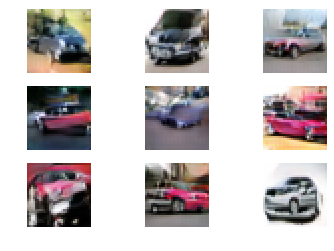

  Epoch: 14, Generator Loss: 2.3420780492134585, Discriminator Loss: [0.35448688 0.        ]


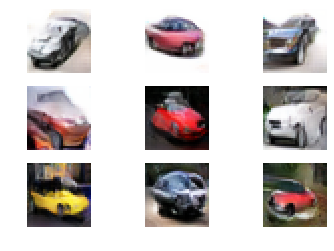

  Epoch: 15, Generator Loss: 2.3894928239094906, Discriminator Loss: [0.3525268 0.       ]


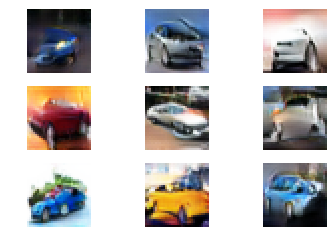

  Epoch: 16, Generator Loss: 2.4290876174584413, Discriminator Loss: [0.36071232 0.        ]


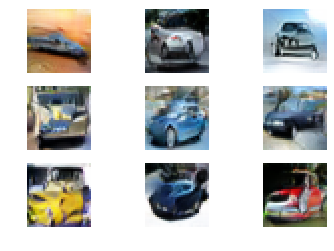

  Epoch: 17, Generator Loss: 2.405041583073445, Discriminator Loss: [0.3498408 0.       ]


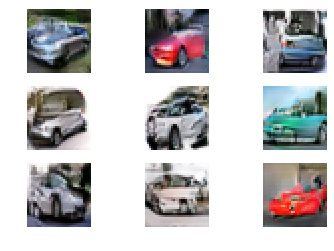

  Epoch: 18, Generator Loss: 2.522914008070261, Discriminator Loss: [0.34486243 0.        ]


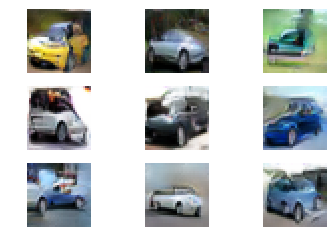

  Epoch: 19, Generator Loss: 2.540879541482681, Discriminator Loss: [0.340509 0.      ]


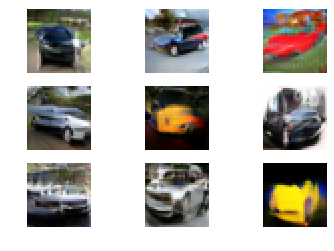

  Epoch: 20, Generator Loss: 2.5501386114420037, Discriminator Loss: [0.34265348 0.        ]


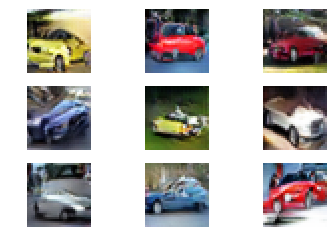

  Epoch: 21, Generator Loss: 2.520187908449234, Discriminator Loss: [0.34006742 0.        ]


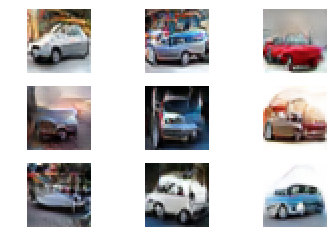

  Epoch: 22, Generator Loss: 2.5949832762663183, Discriminator Loss: [0.33922604 0.        ]


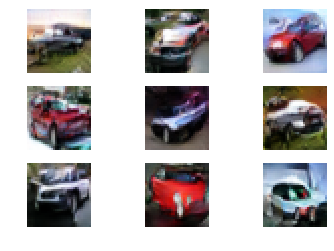

  Epoch: 23, Generator Loss: 2.67916146111794, Discriminator Loss: [0.33690614 0.        ]


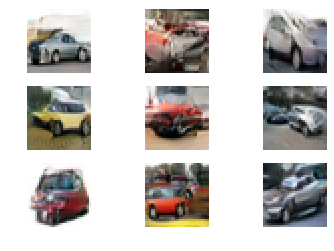

  Epoch: 24, Generator Loss: 2.5992311976658993, Discriminator Loss: [0.3266421 0.       ]


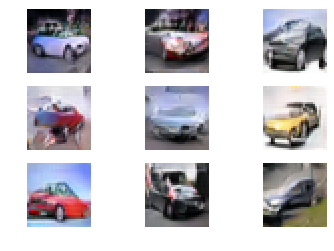

  Epoch: 25, Generator Loss: 2.6675060972189293, Discriminator Loss: [0.3237041 0.       ]


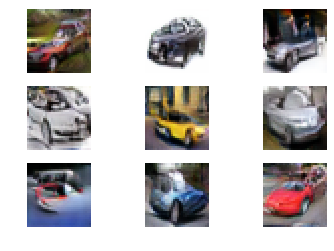

  Epoch: 26, Generator Loss: 2.6891120221370306, Discriminator Loss: [0.3273661 0.       ]


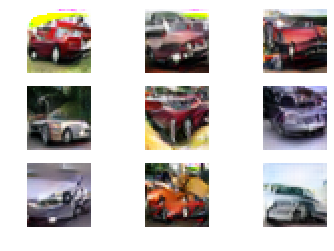

  Epoch: 27, Generator Loss: 2.7279196163782706, Discriminator Loss: [0.32032904 0.        ]


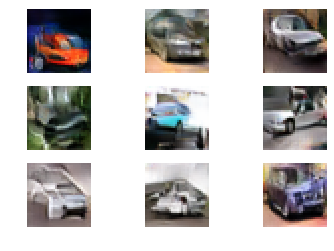

  Epoch: 28, Generator Loss: 2.714416442773281, Discriminator Loss: [0.31868696 0.        ]


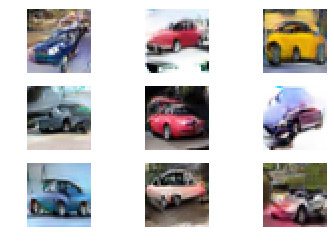

  Epoch: 29, Generator Loss: 2.84011657956319, Discriminator Loss: [0.31692216 0.        ]


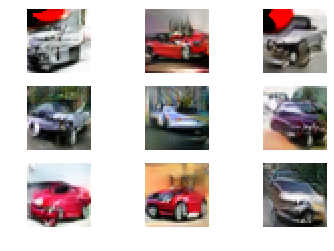

  Epoch: 30, Generator Loss: 2.9140921028760762, Discriminator Loss: [0.30878714 0.        ]


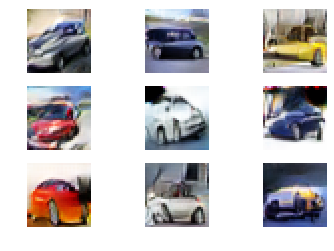

  Epoch: 31, Generator Loss: 2.91305288596031, Discriminator Loss: [0.3083055 0.       ]


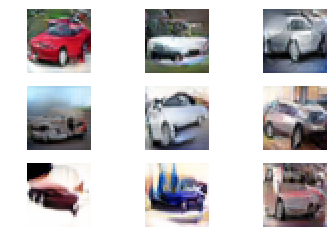

  Epoch: 32, Generator Loss: 2.9373481021477628, Discriminator Loss: [0.31377947 0.        ]


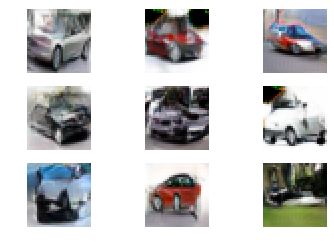

  Epoch: 33, Generator Loss: 2.915898954256987, Discriminator Loss: [0.3002628 0.       ]


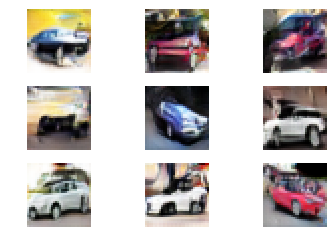

  Epoch: 34, Generator Loss: 2.971026069842852, Discriminator Loss: [0.30555278 0.        ]


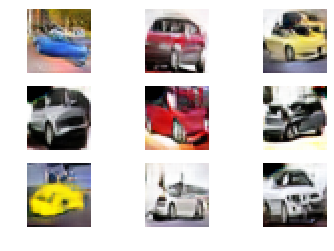

  Epoch: 35, Generator Loss: 2.920435409897413, Discriminator Loss: [0.29371715 0.        ]


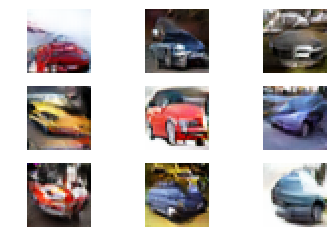

  Epoch: 36, Generator Loss: 2.975287749217107, Discriminator Loss: [0.30269998 0.        ]


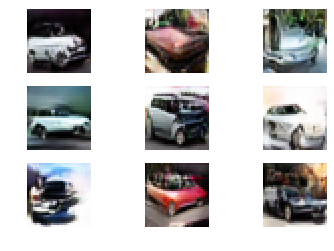

  Epoch: 37, Generator Loss: 2.989588133417643, Discriminator Loss: [0.2975029 0.       ]


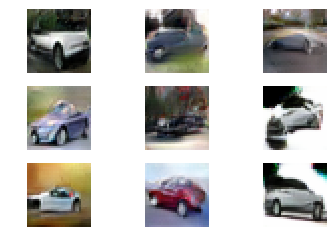

  Epoch: 38, Generator Loss: 2.9952937074196644, Discriminator Loss: [0.30728722 0.        ]


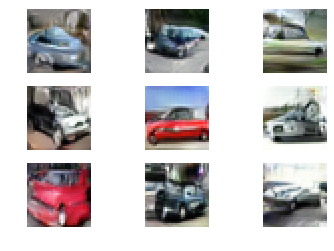

  Epoch: 39, Generator Loss: 3.045553359465721, Discriminator Loss: [0.2989096 0.       ]


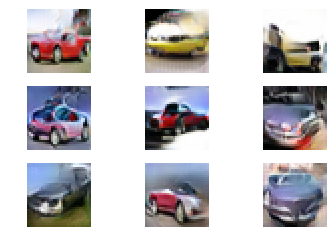

  Epoch: 40, Generator Loss: 2.9462147435316672, Discriminator Loss: [0.29357722 0.        ]


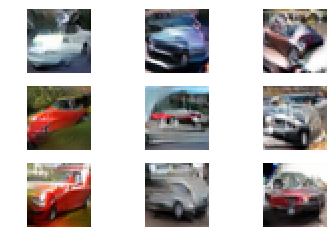

  Epoch: 41, Generator Loss: 3.005022476116816, Discriminator Loss: [0.29333508 0.        ]


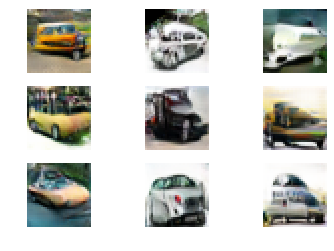

  Epoch: 42, Generator Loss: 3.020905918417833, Discriminator Loss: [0.29380524 0.        ]


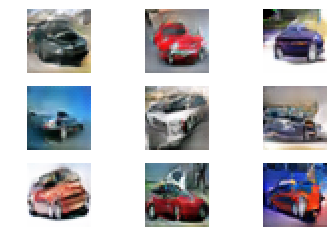

  Epoch: 43, Generator Loss: 3.077938715234781, Discriminator Loss: [0.28789636 0.        ]


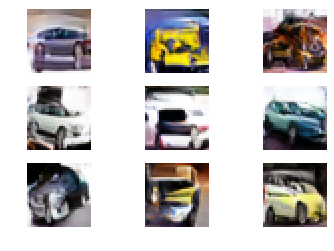

  Epoch: 44, Generator Loss: 3.0464759977200093, Discriminator Loss: [0.28777474 0.        ]


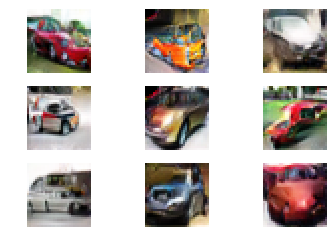

  Epoch: 45, Generator Loss: 3.0597624327891912, Discriminator Loss: [0.28703585 0.        ]


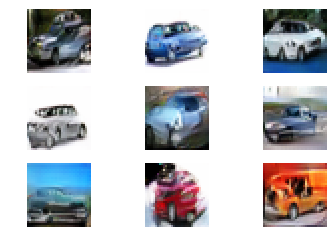

  Epoch: 46, Generator Loss: 2.9818030278652143, Discriminator Loss: [0.28876024 0.        ]


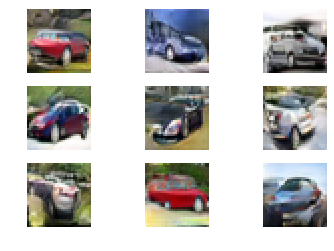

  Epoch: 47, Generator Loss: 3.032138785108542, Discriminator Loss: [0.2870965 0.       ]


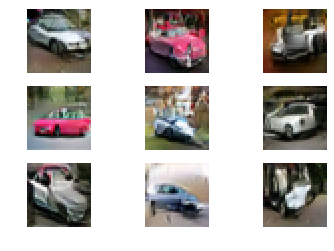

  Epoch: 48, Generator Loss: 2.988081523241141, Discriminator Loss: [0.2781415 0.       ]


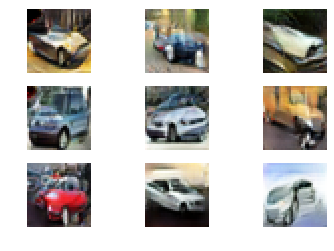

  Epoch: 49, Generator Loss: 3.0963778163378057, Discriminator Loss: [0.28890723 0.        ]


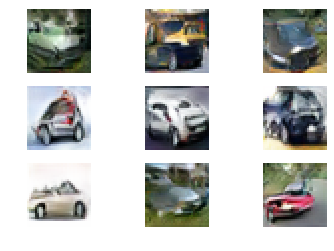

  Epoch: 50, Generator Loss: 3.0315631670065417, Discriminator Loss: [0.2863752 0.       ]


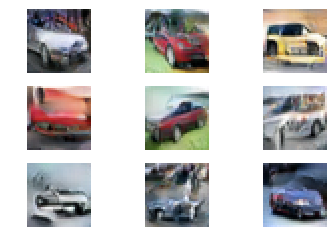

  Epoch: 51, Generator Loss: 2.9836470572612224, Discriminator Loss: [0.28245524 0.        ]


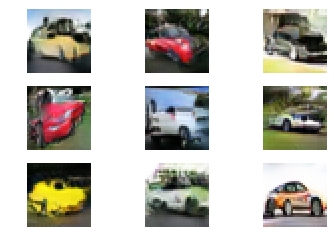

  Epoch: 52, Generator Loss: 3.065694476931523, Discriminator Loss: [0.28363016 0.        ]


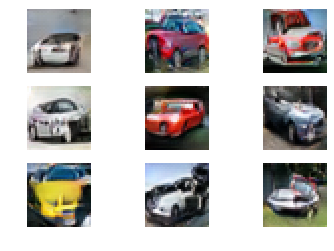

  Epoch: 53, Generator Loss: 3.073991914972281, Discriminator Loss: [0.28594923 0.        ]


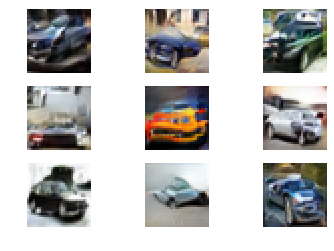

  Epoch: 54, Generator Loss: 3.0609149925219707, Discriminator Loss: [0.27367008 0.        ]


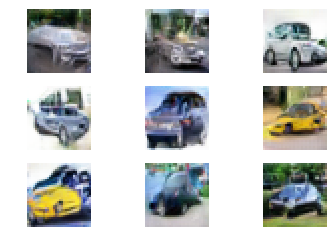

  Epoch: 55, Generator Loss: 3.0012505734578157, Discriminator Loss: [0.28236255 0.        ]


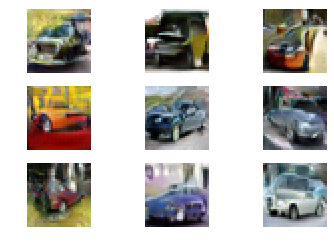

  Epoch: 56, Generator Loss: 3.009577431357824, Discriminator Loss: [0.27835742 0.        ]


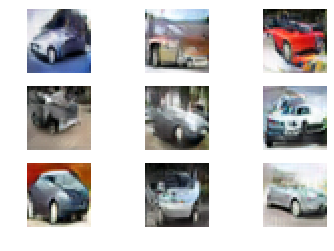

  Epoch: 57, Generator Loss: 3.1041668322988047, Discriminator Loss: [0.2772486 0.       ]


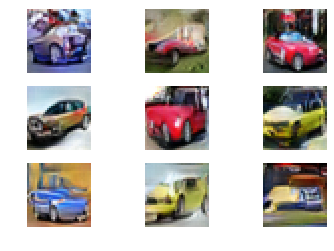

  Epoch: 58, Generator Loss: 3.1037314522724886, Discriminator Loss: [0.2728875 0.       ]


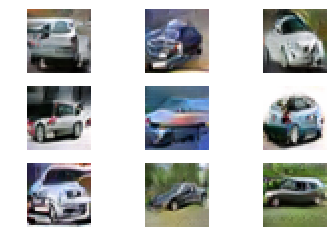

  Epoch: 59, Generator Loss: 3.0897504026309037, Discriminator Loss: [0.2761407 0.       ]


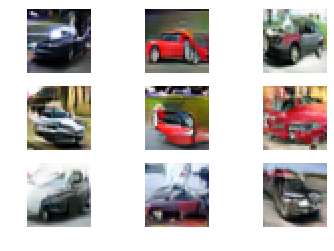

  Epoch: 60, Generator Loss: 3.17407733698686, Discriminator Loss: [0.26938736 0.        ]


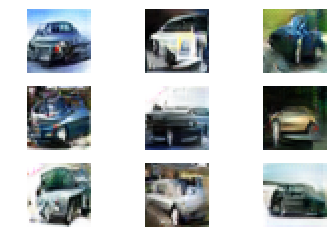

  Epoch: 61, Generator Loss: 3.1717598144060526, Discriminator Loss: [0.27562106 0.        ]


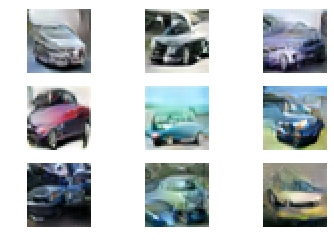

  Epoch: 62, Generator Loss: 3.175673252496964, Discriminator Loss: [0.27547783 0.        ]


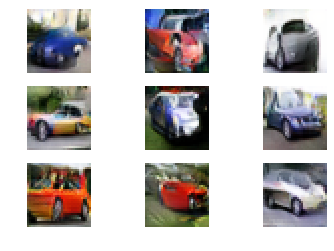

  Epoch: 63, Generator Loss: 3.1562286481643334, Discriminator Loss: [0.27201048 0.        ]


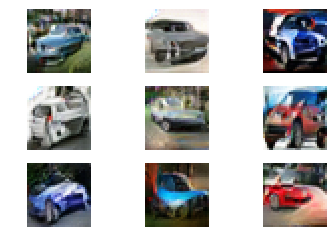

  Epoch: 64, Generator Loss: 3.159433221969849, Discriminator Loss: [0.26141137 0.        ]


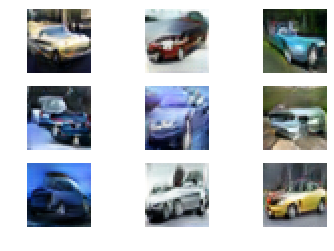

  Epoch: 65, Generator Loss: 3.088835587868324, Discriminator Loss: [0.269837 0.      ]


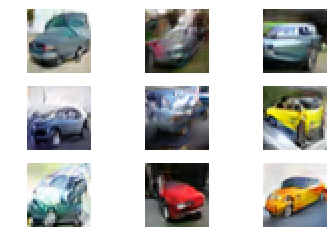

  Epoch: 66, Generator Loss: 3.1426408619452744, Discriminator Loss: [0.26830685 0.        ]


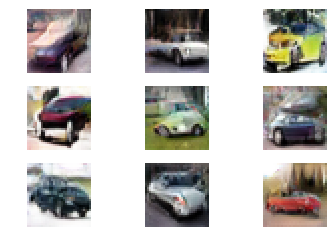

  Epoch: 67, Generator Loss: 3.0993139881354113, Discriminator Loss: [0.25988814 0.        ]


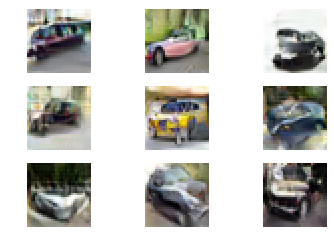

  Epoch: 68, Generator Loss: 3.075546687994248, Discriminator Loss: [0.2680504 0.       ]


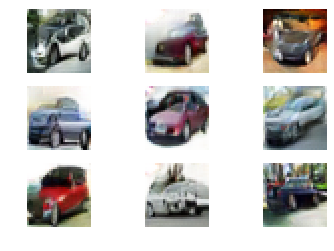

  Epoch: 69, Generator Loss: 3.1195367024495053, Discriminator Loss: [0.26752308 0.        ]


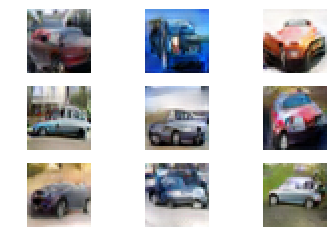

  Epoch: 70, Generator Loss: 3.063069977057286, Discriminator Loss: [0.26593724 0.        ]


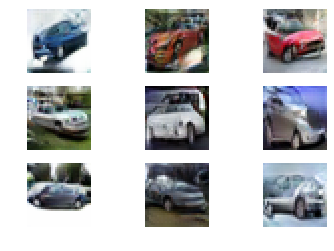

  Epoch: 71, Generator Loss: 3.1599810941097064, Discriminator Loss: [0.26065814 0.        ]


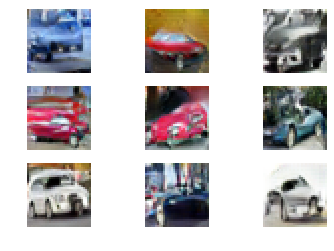

  Epoch: 72, Generator Loss: 3.175816814104716, Discriminator Loss: [0.26219094 0.        ]


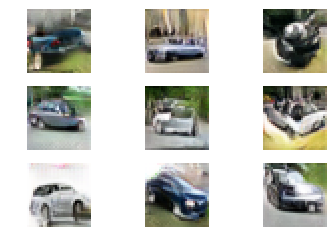

  Epoch: 73, Generator Loss: 3.1054039941384244, Discriminator Loss: [0.2629432 0.       ]


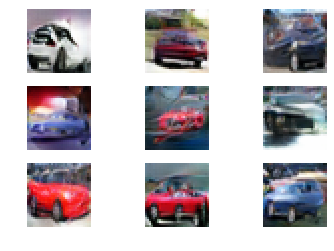

  Epoch: 74, Generator Loss: 3.2029096820415597, Discriminator Loss: [0.25331768 0.        ]


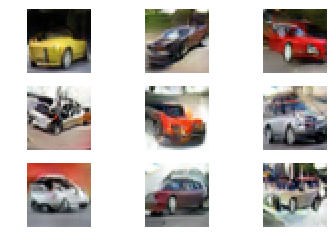

  Epoch: 75, Generator Loss: 3.178017765092544, Discriminator Loss: [0.261865 0.      ]


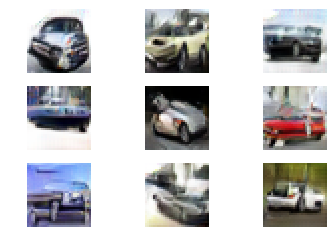

  Epoch: 76, Generator Loss: 3.1190714945013704, Discriminator Loss: [0.25912586 0.        ]


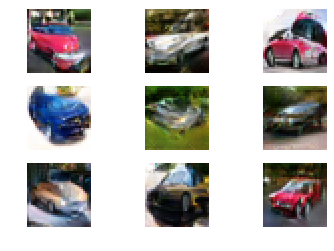

  Epoch: 77, Generator Loss: 3.19107717810533, Discriminator Loss: [0.25489447 0.        ]


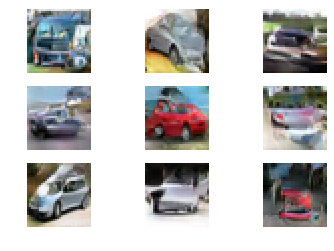

  Epoch: 78, Generator Loss: 3.1753937800725303, Discriminator Loss: [0.25074893 0.        ]


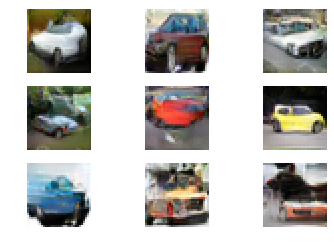

  Epoch: 79, Generator Loss: 3.1051425482982244, Discriminator Loss: [2.6603496e-01 1.0016026e-04]


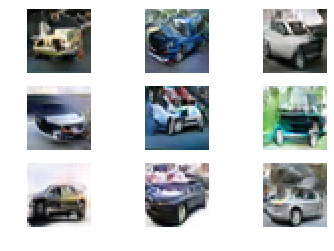

  Epoch: 80, Generator Loss: 3.1374129148629994, Discriminator Loss: [0.25240394 0.        ]


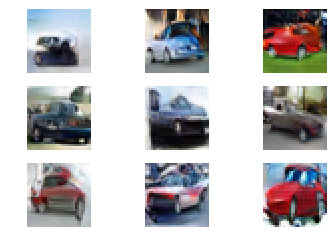

  Epoch: 81, Generator Loss: 3.182717983921369, Discriminator Loss: [0.25924197 0.        ]


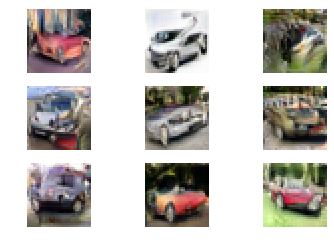

  Epoch: 82, Generator Loss: 3.151962323830678, Discriminator Loss: [0.25569743 0.        ]


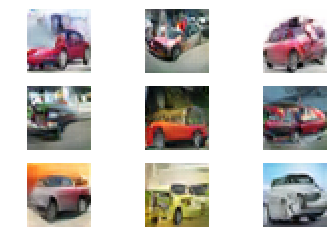

  Epoch: 83, Generator Loss: 3.1945791613215055, Discriminator Loss: [0.24767746 0.        ]


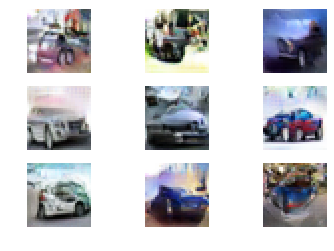

  Epoch: 84, Generator Loss: 3.1177132855623197, Discriminator Loss: [0.26341936 0.        ]


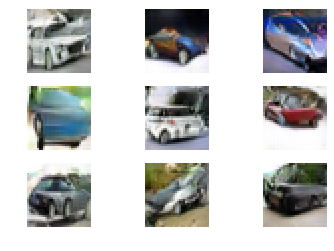

  Epoch: 85, Generator Loss: 3.11608172647464, Discriminator Loss: [0.25697756 0.        ]


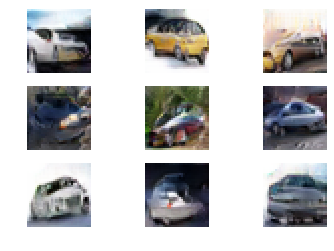

  Epoch: 86, Generator Loss: 3.171534614303173, Discriminator Loss: [0.2471474 0.       ]


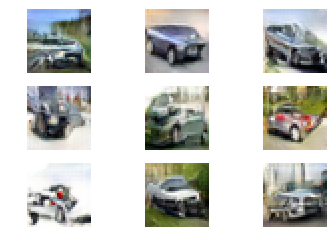

  Epoch: 87, Generator Loss: 3.299029746880898, Discriminator Loss: [0.2438019 0.       ]


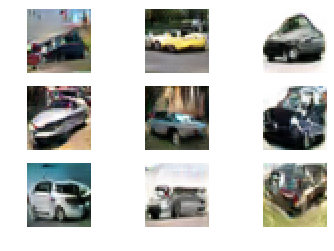

  Epoch: 88, Generator Loss: 3.1645136158435774, Discriminator Loss: [0.24405922 0.        ]


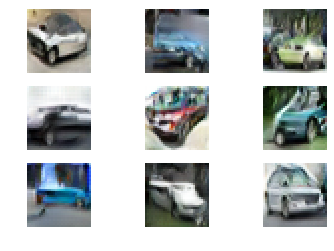

  Epoch: 89, Generator Loss: 3.2090331476468306, Discriminator Loss: [0.25072697 0.        ]


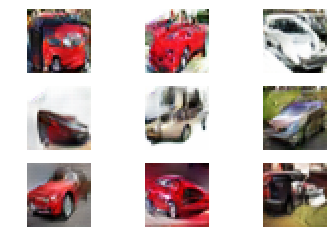

  Epoch: 90, Generator Loss: 3.222188018453427, Discriminator Loss: [0.2528859 0.       ]


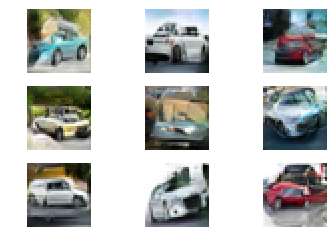

  Epoch: 91, Generator Loss: 3.1587819044406595, Discriminator Loss: [0.2551818 0.       ]


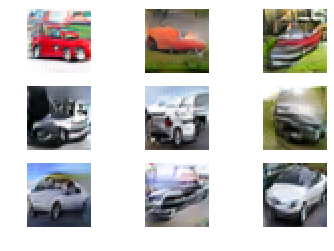

  Epoch: 92, Generator Loss: 3.241312915698076, Discriminator Loss: [0.25520453 0.        ]


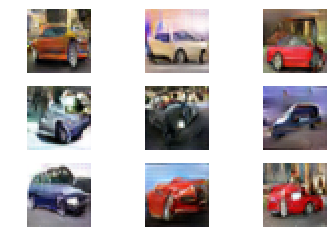

  Epoch: 93, Generator Loss: 3.2051513149188113, Discriminator Loss: [0.24521102 0.        ]


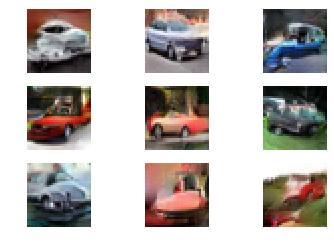

  Epoch: 94, Generator Loss: 3.2688897114533644, Discriminator Loss: [0.24357745 0.        ]


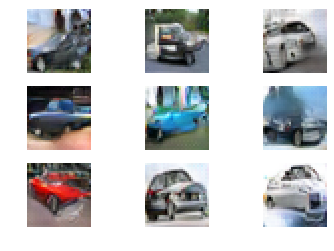

  Epoch: 95, Generator Loss: 3.1786322112266836, Discriminator Loss: [0.25329039 0.        ]


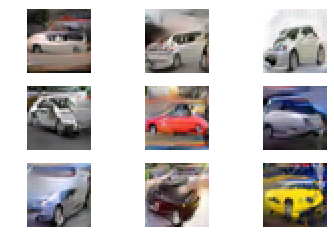

  Epoch: 96, Generator Loss: 3.172424235022985, Discriminator Loss: [0.24610627 0.        ]


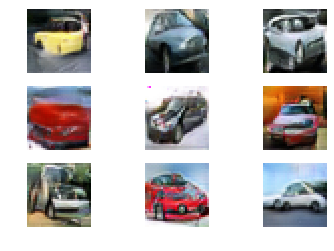

  Epoch: 97, Generator Loss: 3.2070283580284853, Discriminator Loss: [0.24669488 0.        ]


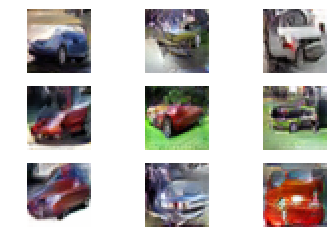

  Epoch: 98, Generator Loss: 3.183133092446205, Discriminator Loss: [0.24236107 0.        ]


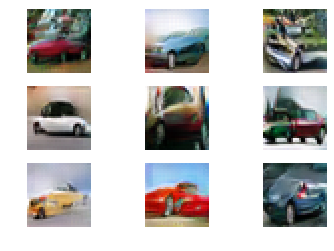

  Epoch: 99, Generator Loss: 3.221202973371897, Discriminator Loss: [0.24817736 0.        ]


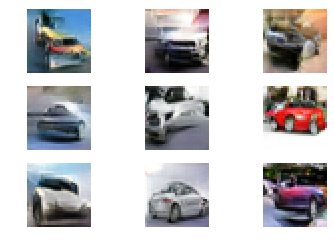

  Epoch: 100, Generator Loss: 3.1759143276856494, Discriminator Loss: [0.24118438 0.        ]


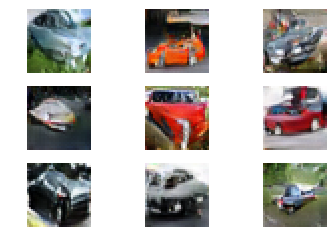

In [11]:
N_EPOCHS = 100
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))
